In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta

import matplotlib.dates as mdates

In [ ]:
df = pd.read_csv(r"C:\Users\abhim\Music\ADA Assignment-1\linkstats.csv")

In [ ]:
df.head(5)

,timestamp,ifHCInOctets,ifHCOutOctets,ifInErrors,ifOutErrors,ifInUcastPackets,ifOutUcastPackets
0,1703858100,3380.495680,2876.390069,0.0,0.0,4.547973,4.646825
1,1703858400,3408.845196,3060.870004,0.0,0.0,4.684506,4.881705
2,1703858700,3378.864965,2789.810337,0.0,0.0,4.659316,4.735553
3,1703859000,3369.610477,3007.387779,0.0,0.0,4.510157,4.723786
4,1703859300,3411.716231,2774.699436,0.0,0.0,4.493931,4.608065


The dataset contains **hourly network traffic measurements** collected from a network interface. The important columns are:

* **timestamp** → Date and time of the measurement.
* **ifHCInOctets** → Total inbound data in octets (bytes).
* **ifHCOutOctets** → Total outbound data in octets (bytes).
* **ifInErrors** → Number of incoming packet errors.
* **ifOutErrors** → Number of outgoing packet errors.
* **ifInUcastPackets** → Number of unicast packets received.
* **ifOutUcastPackets** → Number of unicast packets transmitted.


In [ ]:
df.describe()

,timestamp,ifHCInOctets,ifHCOutOctets,ifInErrors,ifOutErrors,ifInUcastPackets,ifOutUcastPackets
count,2.170400e+04,21704.000000,21704.000000,21704.0,21704.0,21704.000000,21704.000000
mean,1.707115e+09,3662.194603,3121.831474,0.0,0.0,5.849191,5.989371
std,1.881215e+06,2106.497138,2165.381802,0.0,0.0,7.300456,7.306464
min,1.703858e+09,3065.859687,1777.563807,0.0,0.0,4.029608,3.105736
25%,1.705486e+09,3186.130385,2581.760481,0.0,0.0,4.281504,4.410868
50%,1.707117e+09,3233.332602,2640.237080,0.0,0.0,4.401067,4.535204
75%,1.708745e+09,3313.122753,2750.465240,0.0,0.0,4.574064,4.708227
max,1.710373e+09,39759.369003,51812.894384,0.0,0.0,131.925956,131.954822


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21704 entries, 0 to 21703
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          21704 non-null  int64  
 1   ifHCInOctets       21704 non-null  float64
 2   ifHCOutOctets      21704 non-null  float64
 3   ifInErrors         21704 non-null  float64
 4   ifOutErrors        21704 non-null  float64
 5   ifInUcastPackets   21704 non-null  float64
 6   ifOutUcastPackets  21704 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.2 MB


In [ ]:
# Convert UNIX timestamp (in seconds) to pandas datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Set datetime as the index (for easier time series operations)
df = df.set_index('datetime')

# Ensure the rows are sorted chronologically
df = df.sort_index()

# Preview the first few rows
df.head()

,timestamp,ifHCInOctets,ifHCOutOctets,ifInErrors,ifOutErrors,ifInUcastPackets,ifOutUcastPackets
datetime,,,,,,,
2023-12-29 13:55:00,1703858100,3380.495680,2876.390069,0.0,0.0,4.547973,4.646825
2023-12-29 14:00:00,1703858400,3408.845196,3060.870004,0.0,0.0,4.684506,4.881705
2023-12-29 14:05:00,1703858700,3378.864965,2789.810337,0.0,0.0,4.659316,4.735553
2023-12-29 14:10:00,1703859000,3369.610477,3007.387779,0.0,0.0,4.510157,4.723786
2023-12-29 14:15:00,1703859300,3411.716231,2774.699436,0.0,0.0,4.493931,4.608065


In [ ]:
# Resample to hourly averages
hourly_data = df.resample('H').mean()

# Check result
hourly_data.head()

,timestamp,ifHCInOctets,ifHCOutOctets,ifInErrors,ifOutErrors,ifInUcastPackets,ifOutUcastPackets
datetime,,,,,,,
2023-12-29 13:00:00,1.703858e+09,3380.495680,2876.390069,0.0,0.0,4.547973,4.646825
2023-12-29 14:00:00,1.703860e+09,3460.771250,2888.468703,0.0,0.0,4.908369,5.022037
2023-12-29 15:00:00,1.703864e+09,3639.167499,3123.803514,0.0,0.0,5.738568,5.842887
2023-12-29 16:00:00,1.703867e+09,3242.343576,2609.232656,0.0,0.0,4.347367,4.409261
2023-12-29 17:00:00,1.703871e+09,3245.300846,2610.064319,0.0,0.0,4.376476,4.436609


In [ ]:
# Create total utilization (inbound + outbound)
hourly_data['TotalUtilization'] = hourly_data['ifHCInOctets'] + hourly_data['ifHCOutOctets']

hourly_data.head()

,timestamp,ifHCInOctets,ifHCOutOctets,ifInErrors,ifOutErrors,ifInUcastPackets,ifOutUcastPackets,TotalUtilization
datetime,,,,,,,,
2023-12-29 13:00:00,1.703858e+09,3380.495680,2876.390069,0.0,0.0,4.547973,4.646825,6256.885749
2023-12-29 14:00:00,1.703860e+09,3460.771250,2888.468703,0.0,0.0,4.908369,5.022037,6349.239954
2023-12-29 15:00:00,1.703864e+09,3639.167499,3123.803514,0.0,0.0,5.738568,5.842887,6762.971014
2023-12-29 16:00:00,1.703867e+09,3242.343576,2609.232656,0.0,0.0,4.347367,4.409261,5851.576232
2023-12-29 17:00:00,1.703871e+09,3245.300846,2610.064319,0.0,0.0,4.376476,4.436609,5855.365166


In [ ]:
print("Start date:", hourly_data.index.min())
print("End date:", hourly_data.index.max())

Start date: 2023-12-29 13:00:00
End date: 2024-03-13 23:00:00


## Questions are we addressing

- What regression model can best capture and forecast the utilization for the next seven days?  
- What is the appropriate ARIMA model for forecasting future utilization, and how well does it perform?  
- Which exponential smoothing method is suitable for the data, and how do its forecasts compare?  
- How accurate and reliable are the forecasts from different models?  


# EDA and Plot's of Data

In [ ]:
# If Datetime is not index, set it as index
if 'Datetime' in hourly_data.columns:
    hourly_data = hourly_data.set_index('Datetime')

# Create subset with only 'TotalUtilization' column, rename to 'link_utilization'
df_subset = hourly_data[['TotalUtilization']].rename(columns={'TotalUtilization': 'link_utilization'}).copy()

# Check result
print(df_subset.head())
print(df_subset.index)  # Should be DatetimeIndex


                     link_utilization
datetime                             
2023-12-29 13:00:00       6256.885749
2023-12-29 14:00:00       6349.239954
2023-12-29 15:00:00       6762.971014
2023-12-29 16:00:00       5851.576232
2023-12-29 17:00:00       5855.365166
DatetimeIndex(['2023-12-29 13:00:00', '2023-12-29 14:00:00',
               '2023-12-29 15:00:00', '2023-12-29 16:00:00',
               '2023-12-29 17:00:00', '2023-12-29 18:00:00',
               '2023-12-29 19:00:00', '2023-12-29 20:00:00',
               '2023-12-29 21:00:00', '2023-12-29 22:00:00',
               ...
               '2024-03-13 14:00:00', '2024-03-13 15:00:00',
               '2024-03-13 16:00:00', '2024-03-13 17:00:00',
               '2024-03-13 18:00:00', '2024-03-13 19:00:00',
               '2024-03-13 20:00:00', '2024-03-13 21:00:00',
               '2024-03-13 22:00:00', '2024-03-13 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=1811, freq='h')


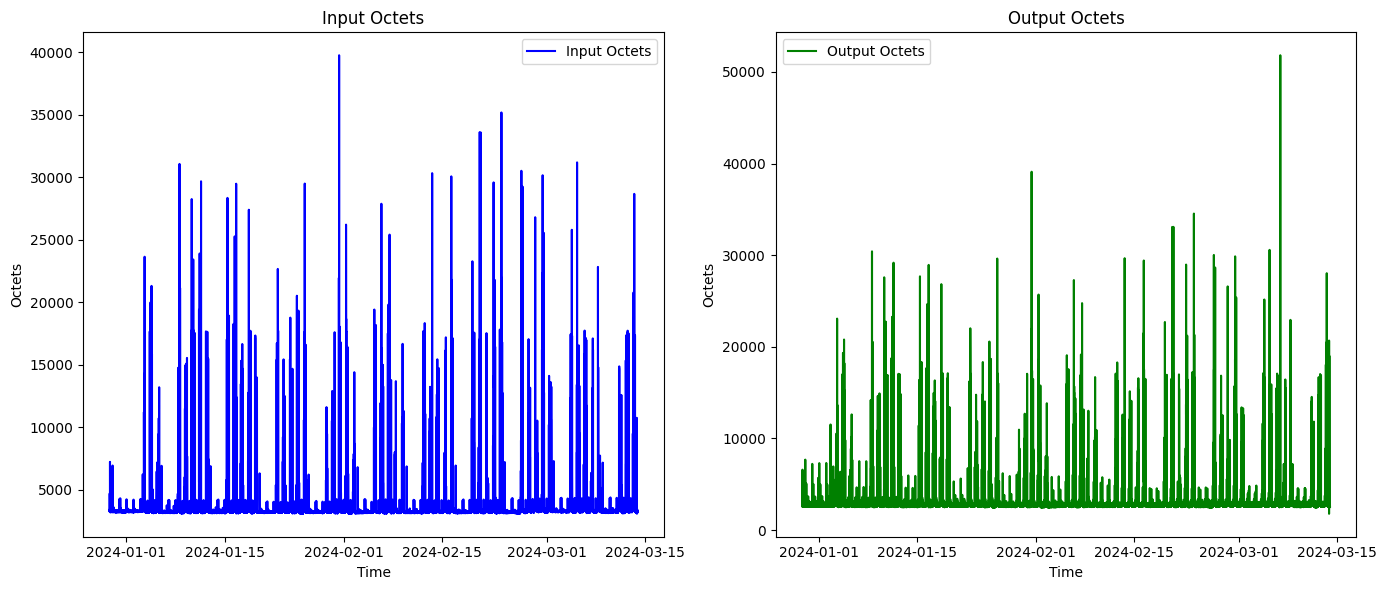

In [ ]:
# Plot the Input and Output Octets over time
plt.figure(figsize=(14, 6))

# Left subplot: Input Octets
plt.subplot(1, 2, 1)
plt.plot(df['ifHCInOctets'], label='Input Octets', color='blue')
plt.title('Input Octets')
plt.xlabel('Time')
plt.ylabel('Octets')
plt.legend()

# Right subplot: Output Octets
plt.subplot(1, 2, 2)
plt.plot(df['ifHCOutOctets'], label='Output Octets', color='green')
plt.title('Output Octets')
plt.xlabel('Time')
plt.ylabel('Octets')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

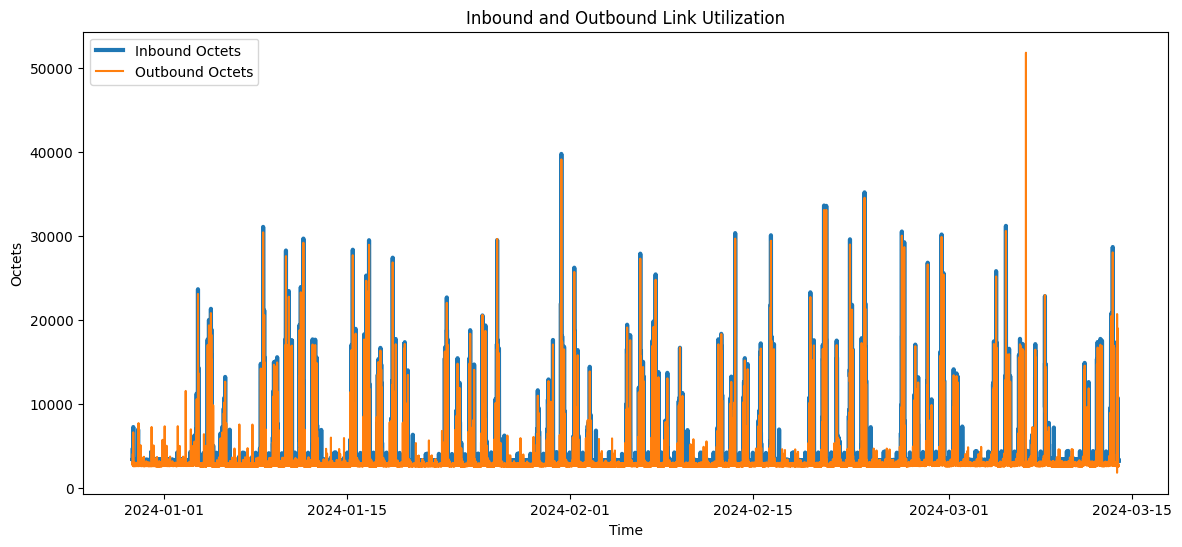

In [ ]:
# Plot inbound and outbound octets
plt.figure(figsize=(14,6))
plt.plot(df['ifHCInOctets'], label='Inbound Octets',linewidth=3)
plt.plot(df['ifHCOutOctets'], label='Outbound Octets')
plt.title('Inbound and Outbound Link Utilization')
plt.xlabel('Time')
plt.ylabel('Octets')
plt.legend()
plt.show()

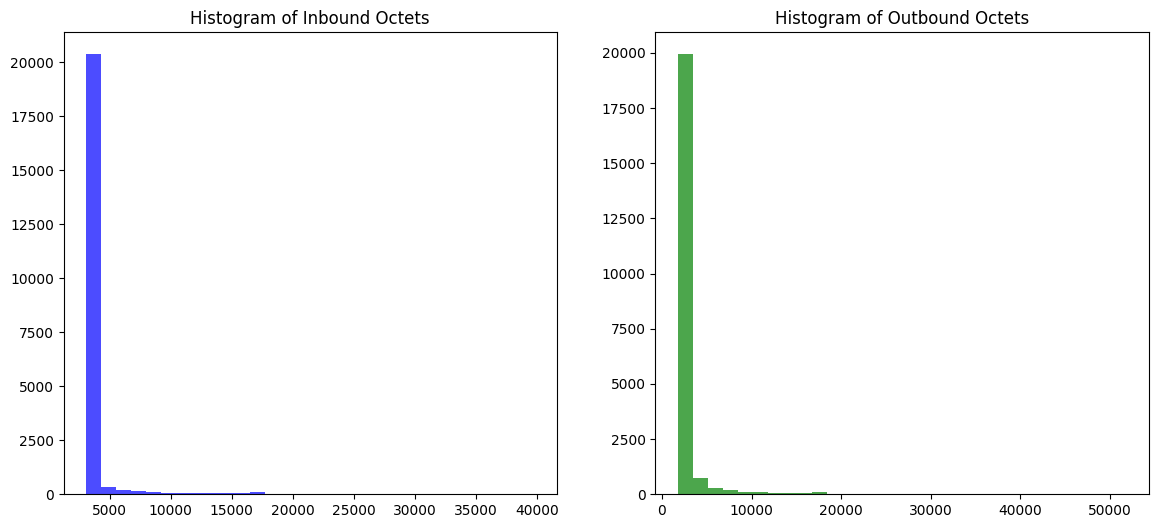

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(df['ifHCInOctets'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Inbound Octets')
plt.subplot(1, 2, 2)
plt.hist(df['ifHCOutOctets'].dropna(), bins=30, color='green', alpha=0.7)
plt.title('Histogram of Outbound Octets')
plt.show()


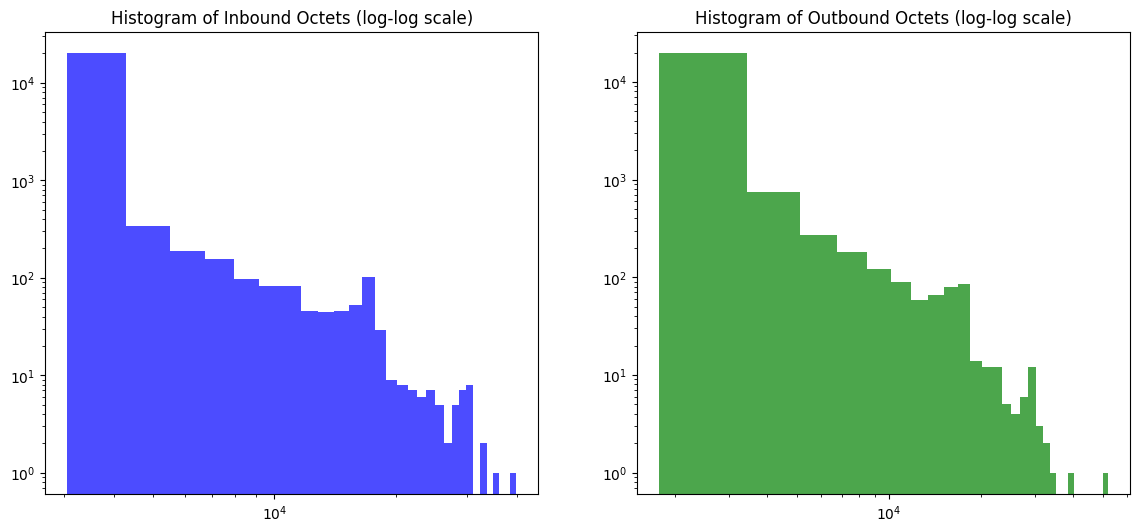

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(df['ifHCInOctets'].dropna(), bins=30, color='blue', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title('Histogram of Inbound Octets (log-log scale)')
plt.subplot(1, 2, 2)
plt.hist(df['ifHCOutOctets'].dropna(), bins=30, color='green', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title('Histogram of Outbound Octets (log-log scale)')
plt.show()

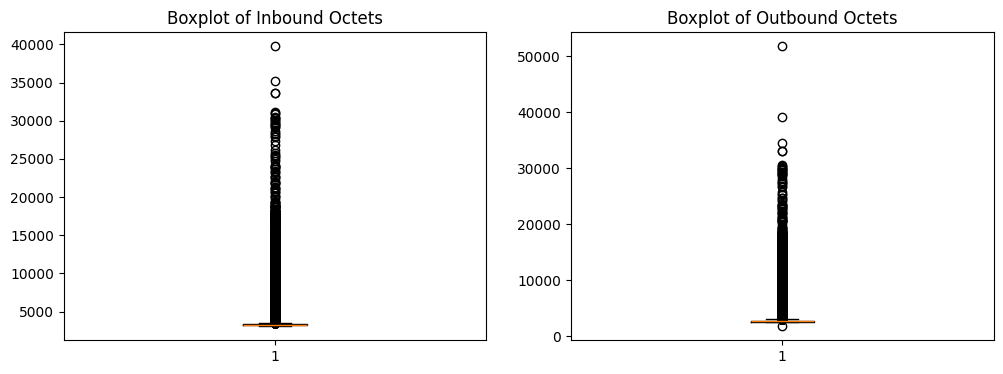

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.boxplot(df['ifHCInOctets'].dropna())
plt.title('Boxplot of Inbound Octets')
plt.subplot(1, 2, 2)
plt.boxplot(df['ifHCOutOctets'].dropna())
plt.title('Boxplot of Outbound Octets')
plt.show()

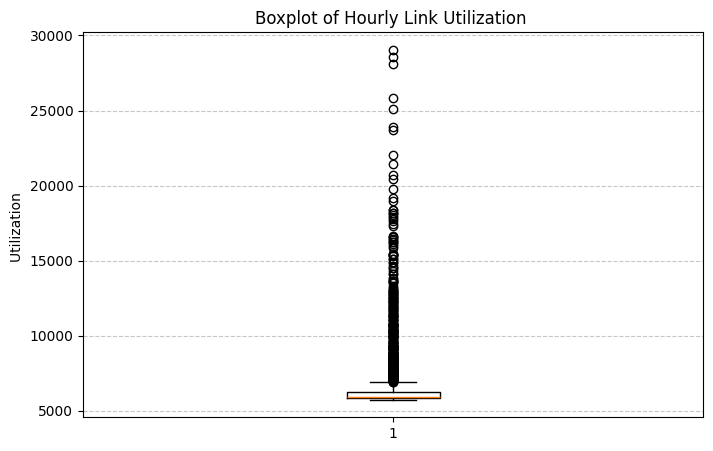

In [ ]:
plt.figure(figsize=(8, 5))
plt.boxplot(df_subset['link_utilization'].dropna())
plt.title('Boxplot of Hourly Link Utilization ')
plt.ylabel('Utilization ')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

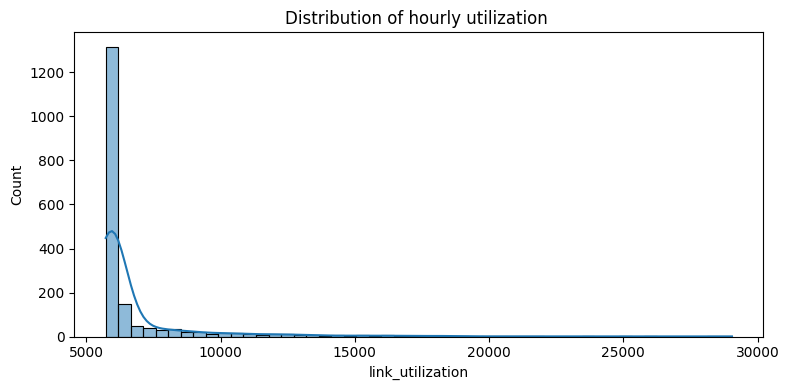

In [ ]:
# Plot of distribution
plt.figure(figsize=(8,4))
sns.histplot(df_subset["link_utilization"].dropna(), bins=50, kde=True)
plt.title('Distribution of hourly utilization ')
plt.tight_layout()
plt.show()

# Task-1: Regression Model

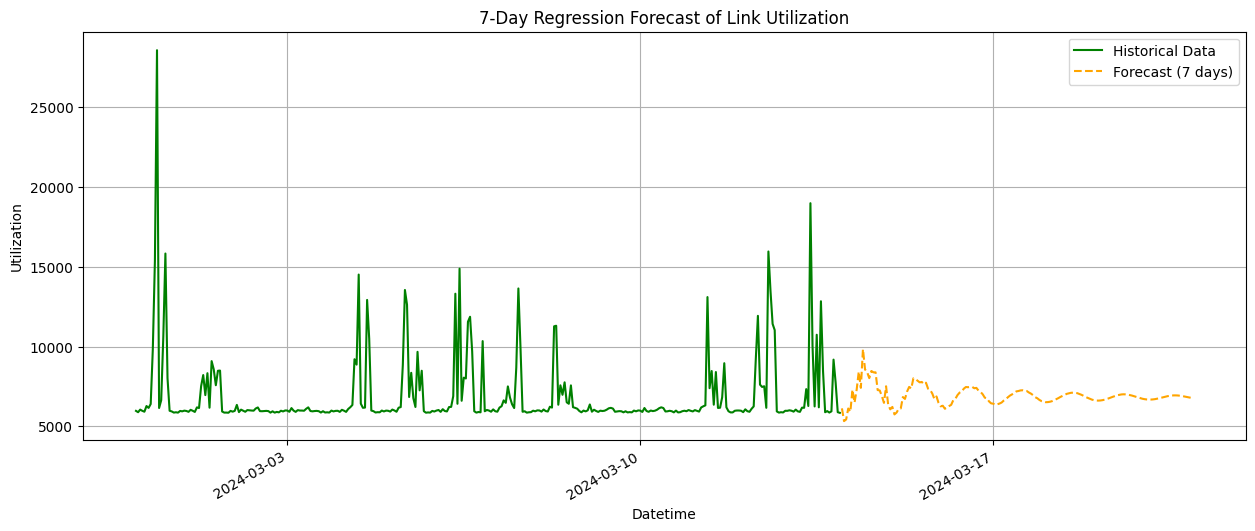


Seven-day forecast (first 20 values):

              Datetime  PredictedUtilization
0  2024-03-14 00:00:00           6125.358007
1  2024-03-14 01:00:00           5326.370156
2  2024-03-14 02:00:00           5430.540422
3  2024-03-14 03:00:00           6117.295971
4  2024-03-14 04:00:00           5911.136804
5  2024-03-14 05:00:00           7290.256611
6  2024-03-14 06:00:00           6489.559066
7  2024-03-14 07:00:00           7288.889500
8  2024-03-14 08:00:00           8423.887018
9  2024-03-14 09:00:00           7413.449392
10 2024-03-14 10:00:00           9833.014065
11 2024-03-14 11:00:00           8562.147706
12 2024-03-14 12:00:00           8397.178938
13 2024-03-14 13:00:00           8021.868051
14 2024-03-14 14:00:00           8469.289962
15 2024-03-14 15:00:00           8383.673958
16 2024-03-14 16:00:00           8383.819525
17 2024-03-14 17:00:00           7273.551612
18 2024-03-14 18:00:00           7245.995717
19 2024-03-14 19:00:00           6893.495707


In [ ]:
"""
Regression-based autoregressive model for hourly link utilization.

It uses the last 24 hours as predictors and then performs recursive
forecasting to extend predictions for the next 7 days.
"""

# Step 1: Make a working copy of the dataset
util_data = hourly_data.copy()

# Step 2: Construct lagged features (past 24 hours)
num_lags = 24
lag_data = pd.DataFrame({'target': util_data['TotalUtilization']})

for lag in range(1, num_lags + 1):
    lag_data[f'lag_{lag}'] = lag_data['target'].shift(lag)

lag_data.dropna(inplace=True)

# Step 3: Prepare inputs and outputs, then split into train/test
X_all = lag_data.drop('target', axis=1)
y_all = lag_data['target']
test_size = 7 * 24   # hold out one week

X_train, X_test = X_all[:-test_size], X_all[-test_size:]
y_train, y_test = y_all[:-test_size], y_all[-test_size:]

# Step 4: Fit linear regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Step 5: Recursive prediction loop
past_vals = y_train.tail(num_lags).tolist()
future_preds = []
forecast_steps = 7 * 24

for _ in range(forecast_steps):
    X_input = pd.DataFrame([past_vals[-num_lags:]], columns=X_train.columns)
    next_val = reg_model.predict(X_input)[0]
    future_preds.append(next_val)
    past_vals.append(next_val)

# Step 6: Build future datetime index and plot results
last_time = util_data.index[-1]
future_time = pd.date_range(start=last_time + pd.Timedelta(hours=1),
                            periods=forecast_steps, freq='H')

fig, ax = plt.subplots(figsize=(15, 6))

# Plot historical data (last ~14 days)
ax.plot(util_data.index[-test_size*2:], util_data['TotalUtilization'][-test_size*2:],
        label='Historical Data', color='green')

# Plot forecasted values
ax.plot(future_time, future_preds, label='Forecast (7 days)', color='orange', linestyle='--')

# Format date ticks
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

ax.legend()
ax.set_title("7-Day Regression Forecast of Link Utilization")
ax.set_xlabel("Datetime")
ax.set_ylabel("Utilization")
ax.grid(True)
plt.show()

# Step 7: Display forecast table
forecast_table = pd.DataFrame({
    "Datetime": future_time,
    "PredictedUtilization": future_preds
})
print("\nSeven-day forecast (first 20 values):\n")
print(forecast_table.head(20))

Test Set Evaluation (Regression Model)
Mean Squared Error (MSE):        3185327.16
Root Mean Squared Error (RMSE):  1784.75
Mean Absolute Error (MAE):       953.73
R-squared (R²):                  0.1879
Mean Absolute Percentage Error:  11.94%


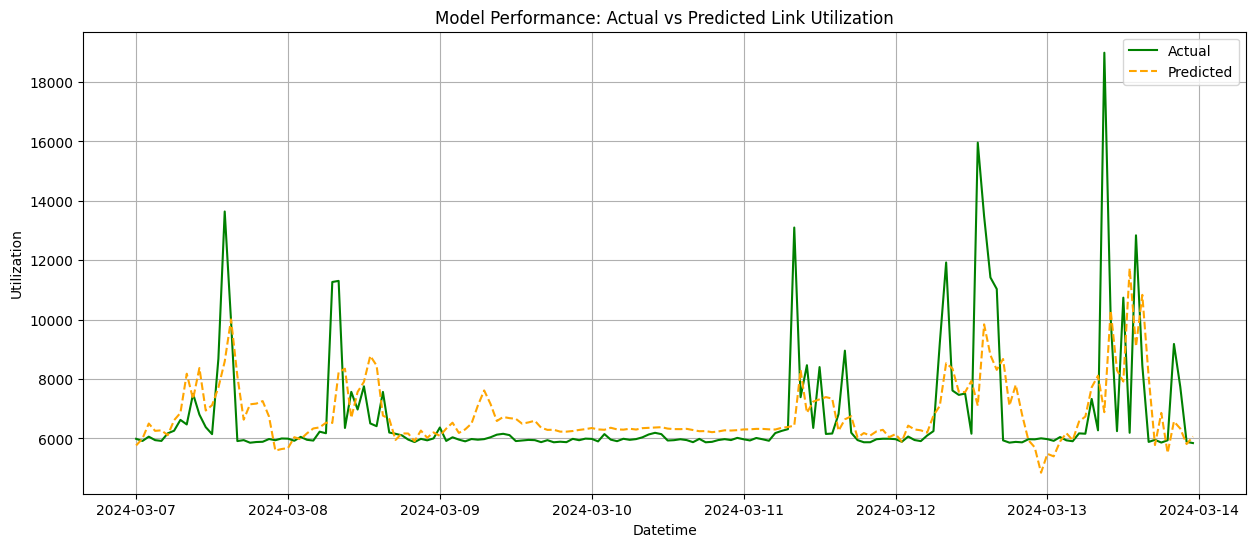

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Predictions for the test set
test_preds = reg_model.predict(X_test)

# Step 2: Evaluate performance with error metrics
mse_val = mean_squared_error(y_test, test_preds)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_test, test_preds)
r2_val = r2_score(y_test, test_preds)
mape_val = np.mean(np.abs((y_test - test_preds) / y_test)) * 100

print("Test Set Evaluation (Regression Model)")
print(f"Mean Squared Error (MSE):        {mse_val:.2f}")
print(f"Root Mean Squared Error (RMSE):  {rmse_val:.2f}")
print(f"Mean Absolute Error (MAE):       {mae_val:.2f}")
print(f"R-squared (R²):                  {r2_val:.4f}")
print(f"Mean Absolute Percentage Error:  {mape_val:.2f}%")

# Step 3: Plot actual vs predicted on test data
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual', color='green')
plt.plot(y_test.index, test_preds, label='Predicted', color='orange', linestyle='--')
plt.legend()
plt.title("Model Performance: Actual vs Predicted Link Utilization")
plt.xlabel("Datetime")
plt.ylabel("Utilization")
plt.grid(True)
plt.show()

## Task 1: Regression Model Performance

The first model used was a simple regression approach. It served as a baseline and captured limited variance.

- **R²**: 0.1879  
- **RMSE**: 1784.75  
- **MAE**: 953.73  
- **MAPE**: 11.94%  

Regression explained only ~18.8% of the variance, showing moderate predictive ability but missing seasonality.


### Residual for Regression

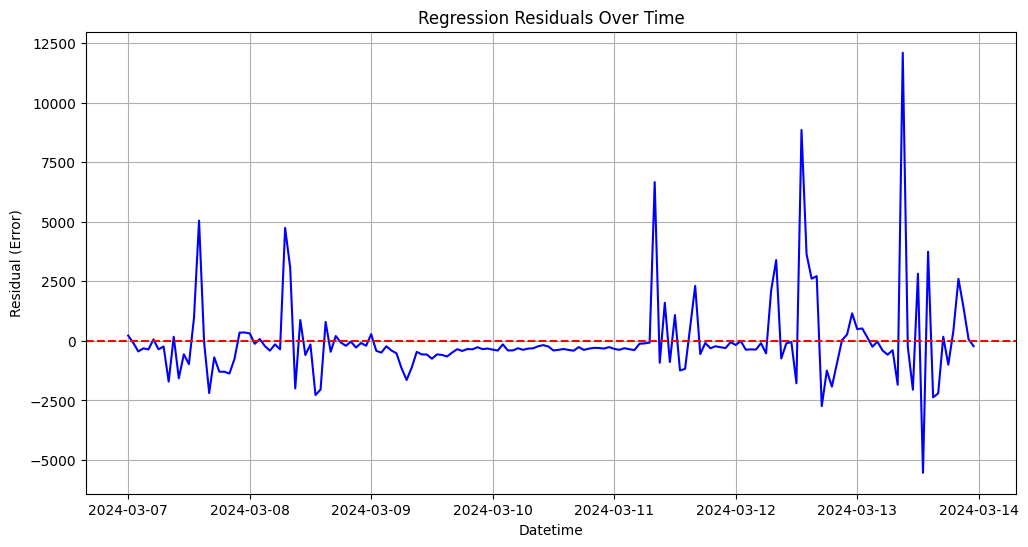

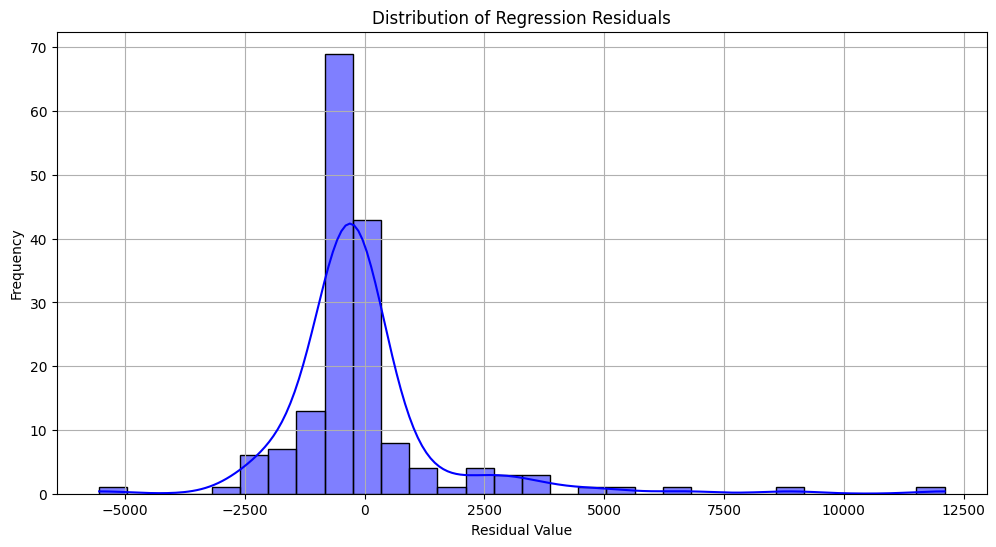


--- Residual Summary Statistics ---
count      168.000000
mean       -11.715621
std       1790.045502
min      -5535.118827
25%       -521.415920
50%       -310.899518
75%        -32.030672
max      12102.489787
Name: target, dtype: float64


In [ ]:
# --- Residual Analysis for Regression Model ---

# Calculate the residuals using the correct variable name
residuals = y_test - test_preds

# --- Create Diagnostic Plots ---

# Plot 1: Residuals over time
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, residuals, color='blue')  # set line color to blue
plt.axhline(0, color='red', linestyle='--') # Add a horizontal line at zero
plt.title('Regression Residuals Over Time')
plt.xlabel('Datetime')
plt.ylabel('Residual (Error)')
plt.grid(True)
plt.show()

# Plot 2: Histogram + KDE
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue', line_kws={'color': 'blue'})
plt.title('Distribution of Regression Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# --- Print Summary Statistics of Residuals ---
print("\n--- Residual Summary Statistics ---")
print(residuals.describe())

## Analysis of Linear Regression Model Residuals

The Linear Regression model was used as a baseline to predict link utilization.  
An analysis of its residuals (prediction errors) provides insights into how well the model performed.

---

### 1. Residuals Over Time
The residuals over time fluctuate widely, with large positive and negative spikes.  
They are not consistently centered around zero, which suggests that the regression model did not fully capture the underlying structure of the data. Outliers in traffic led to very large deviations between predictions and actual values.

---

### 2. Distribution of Residuals
The residuals do not follow a perfect bell-curve distribution. Instead, they show heavy spread and skewness.  
This indicates that the model sometimes **underestimates utilization heavily** and sometimes **overestimates significantly**, leading to inconsistent prediction accuracy.

---

### 3. Summary Statistics
Key descriptive statistics of the residuals are:  
- **mean**: -11.71 (close to zero, suggesting little bias overall)  
- **std**: 1790.05 (large standard deviation indicates wide error spread)  
- **min**: -5535.12  
- **max**: 12102.49  

---

### **Conclusion**
The regression model explained only **18.8% of the variance (R² = 0.1879)** and had an **RMSE of 1784.75**.  
Although unbiased on average, the large error variance shows it was **not effective in handling fluctuations or seasonality**, making it a weak predictive model.


# Task-2: ARIMA Model

In [ ]:
from statsmodels.tsa.stattools import adfuller

print("ADF Test for Stationarity:")
adf_result = adfuller(hourly_data['TotalUtilization'])
print(f'ADF Statistic: {adf_result[0]:.2f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:', adf_result[4])
if adf_result[1] < 0.05:
    print("Series is stationary (p < 0.05).")
else:
    print("Series is non-stationary (p >= 0.05); consider differencing (d=1).")

ADF Test for Stationarity:
ADF Statistic: -5.26
p-value: 0.0000
Critical Values: {'1%': np.float64(-3.434018755659214), '5%': np.float64(-2.8631605515716476), '10%': np.float64(-2.5676327303470408)}
Series is stationary (p < 0.05).


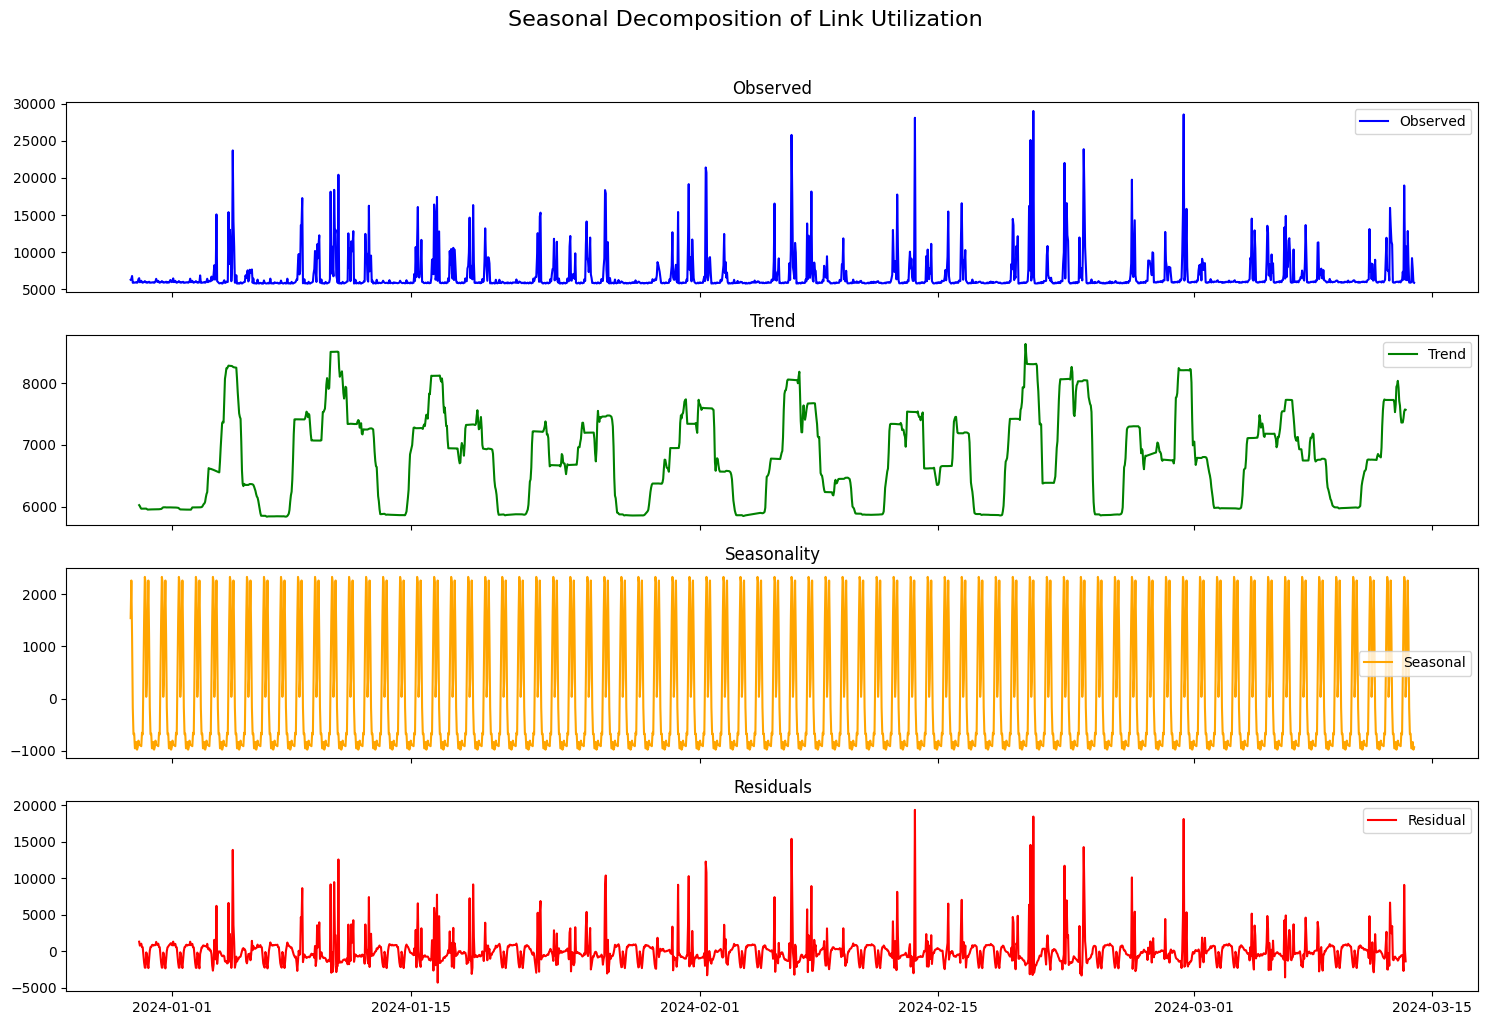

In [ ]:
result = seasonal_decompose(hourly_data['TotalUtilization'], model='additive', period=24)

fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

axes[0].plot(result.observed, label="Observed", color="blue")
axes[0].set_title("Observed")
axes[0].legend()

axes[1].plot(result.trend, label="Trend", color="green")
axes[1].set_title("Trend")
axes[1].legend()

axes[2].plot(result.seasonal, label="Seasonal", color="orange")
axes[2].set_title("Seasonality")
axes[2].legend()

axes[3].plot(result.resid, label="Residual", color="red")
axes[3].set_title("Residuals")
axes[3].legend()

plt.suptitle("Seasonal Decomposition of Link Utilization", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


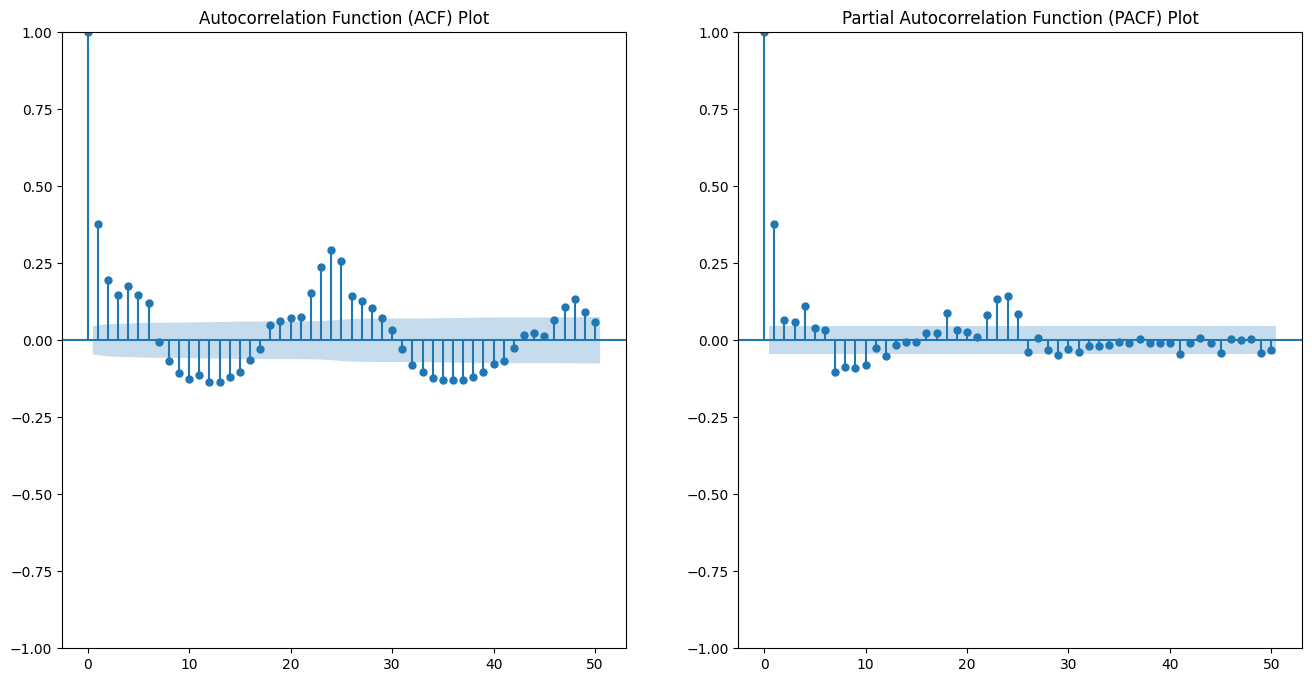

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(16, 8))
plt.subplot(121)
plot_acf(hourly_data['TotalUtilization'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) Plot')
plt.subplot(122)
plot_pacf(hourly_data['TotalUtilization'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.show()

In [ ]:
def pq_top_dips(series, nlags=40, top_n=2, min_lag=5):

    acf_vals = acf(series, nlags=nlags, fft=False)
    pacf_vals = pacf(series, nlags=nlags, method='yw')
    acf_vals[0] = pacf_vals[0] = np.nan

    acf_diffs = np.diff(acf_vals)
    pacf_diffs = np.diff(pacf_vals)
    acf_sorted = np.argsort(acf_diffs) + 1
    pacf_sorted = np.argsort(pacf_diffs) + 1

    acf_candidates = [lag for lag in acf_sorted if lag >= min_lag][:top_n]
    pacf_candidates = [lag for lag in pacf_sorted if lag >= min_lag][:top_n]

    print("Top PACF dips (p candidates, lag ≥ 5):")
    for i, lag in enumerate(pacf_candidates, 1):
        print(f"{i}. Lag {lag}, drop={pacf_diffs[lag-1]:.4f}")

    print("\nTop ACF dips (q candidates, lag ≥ 5):")
    for i, lag in enumerate(acf_candidates, 1):
        print(f"{i}. Lag {lag}, drop={acf_diffs[lag-1]:.4f}")

    return pacf_candidates, acf_candidates
p_candidates, q_candidates = pq_top_dips(hourly_data['TotalUtilization'], nlags=40)

Top PACF dips (p candidates, lag ≥ 5):
1. Lag 7, drop=-0.1364
2. Lag 26, drop=-0.1258

Top ACF dips (q candidates, lag ≥ 5):
1. Lag 7, drop=-0.1264
2. Lag 26, drop=-0.1144


In [ ]:
warnings.filterwarnings("ignore")
p_candidates = [6, 7, 26]
q_candidates = [6, 8, 26]
d = 0
# --- Data ---
series = hourly_data['TotalUtilization']
train, test = series[:-168], series[-168:]
results = []

# --- Train and Evaluate ARIMA models ---
for p in p_candidates:
    for q in q_candidates:
        order = (p, d, q)
        model = ARIMA(train, order=order)
        fit = model.fit()
        forecast = fit.forecast(steps=len(test))
        mse = mean_squared_error(test, forecast)
        results.append(((p, 0, q), mse, fit.aic, fit.bic, forecast))
        print(f"ARIMA{order} -> MSE={mse:.2f}, AIC={fit.aic:.2f}, BIC={fit.bic:.2f}")


# --- Sort results by MSE ---
results = sorted(results, key=lambda x: x[1])


ARIMA(6, 0, 6) -> MSE=3683636.27, AIC=30003.40, BIC=30079.06
ARIMA(6, 0, 8) -> MSE=3553965.68, AIC=30004.24, BIC=30090.71
ARIMA(6, 0, 26) -> MSE=3770109.07, AIC=29966.82, BIC=30150.56
ARIMA(7, 0, 6) -> MSE=3373615.85, AIC=29996.29, BIC=30077.35
ARIMA(7, 0, 8) -> MSE=3922383.10, AIC=30058.97, BIC=30150.85
ARIMA(7, 0, 26) -> MSE=3770401.94, AIC=29968.14, BIC=30157.29
ARIMA(26, 0, 6) -> MSE=3690283.23, AIC=29959.23, BIC=30142.98
ARIMA(26, 0, 8) -> MSE=3699062.90, AIC=29963.41, BIC=30157.96
ARIMA(26, 0, 26) -> MSE=3345953.94, AIC=29982.44, BIC=30274.27


In [ ]:
# --- Top 3 models ---
print("\nTop 3 ARIMA models:")

top_models = {}
for rank, (order, mse, aic, bic, _) in enumerate(results[:3], start=1):
    print(f"Rank {rank}: ARIMA{order} -> MSE={mse:.2f}, AIC={aic:.2f}, BIC={bic:.2f}")
    top_models[rank] = {"p": order[0], "d": order[1], "q": order[2]}

# print("\nStored Top Models Dict:")
# print(top_models)


Top 3 ARIMA models:
Rank 1: ARIMA(26, 0, 26) -> MSE=3345953.94, AIC=29982.44, BIC=30274.27
Rank 2: ARIMA(7, 0, 6) -> MSE=3373615.85, AIC=29996.29, BIC=30077.35
Rank 3: ARIMA(6, 0, 8) -> MSE=3553965.68, AIC=30004.24, BIC=30090.71


In [ ]:
best_order, best_mse, best_aic, best_bic, ARIMA_y_pred = results[0]

In [ ]:
# --- Evaluation metrics ---

mse = mean_squared_error(y_test, ARIMA_y_pred)
rmse = root_mean_squared_error(y_test, ARIMA_y_pred)
mae = mean_absolute_error(y_test, ARIMA_y_pred)
r2 = r2_score(y_test, ARIMA_y_pred)
mape = np.mean(np.abs((y_test - ARIMA_y_pred) / y_test)) * 100

print("ARIMA Model Evaluation Metrics:")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"R²   : {r2:.4f}")
print(f"MAPE : {mape:.2f}%")

ARIMA Model Evaluation Metrics:
MSE  : 3345953.94
RMSE : 1829.19
MAE  : 1088.57
R²   : 0.1470
MAPE : 13.80%


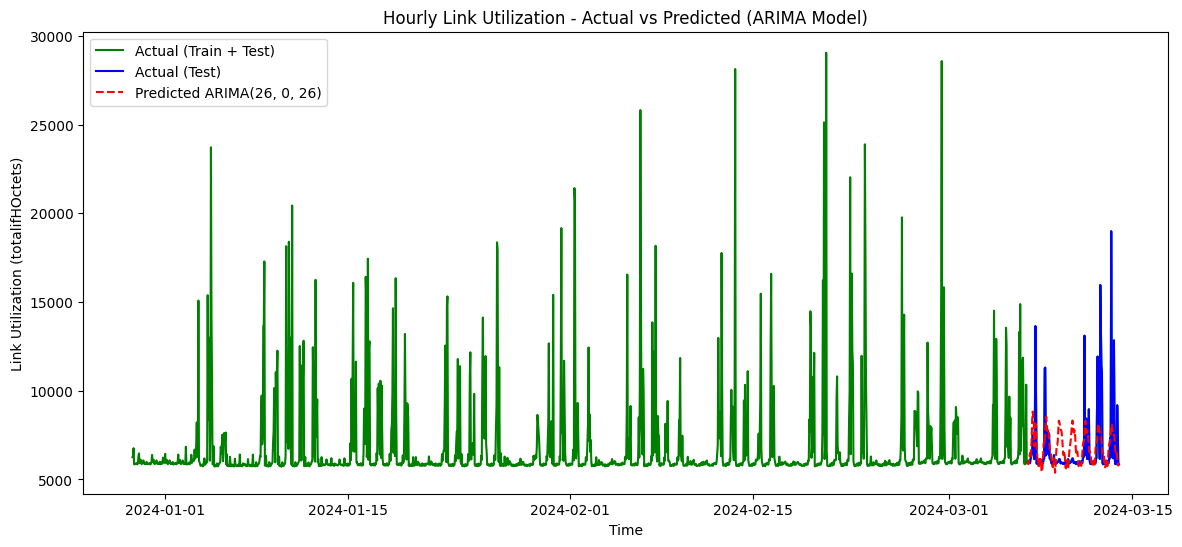

In [ ]:
plt.figure(figsize=(14,6))

# Use 'series' which holds the full time series data
plt.plot(series.index, series, label="Actual (Train + Test)", color="green")

# These lines are already correct
plt.plot(series.index[-168:], test, label="Actual (Test)", color="blue")
plt.plot(series.index[-168:], ARIMA_y_pred, label=f"Predicted ARIMA{best_order}", color="red", linestyle="--")

plt.title("Hourly Link Utilization - Actual vs Predicted (ARIMA Model)")
plt.xlabel("Time")
plt.ylabel("Link Utilization (totalifHOctets)")
plt.legend()
plt.show()

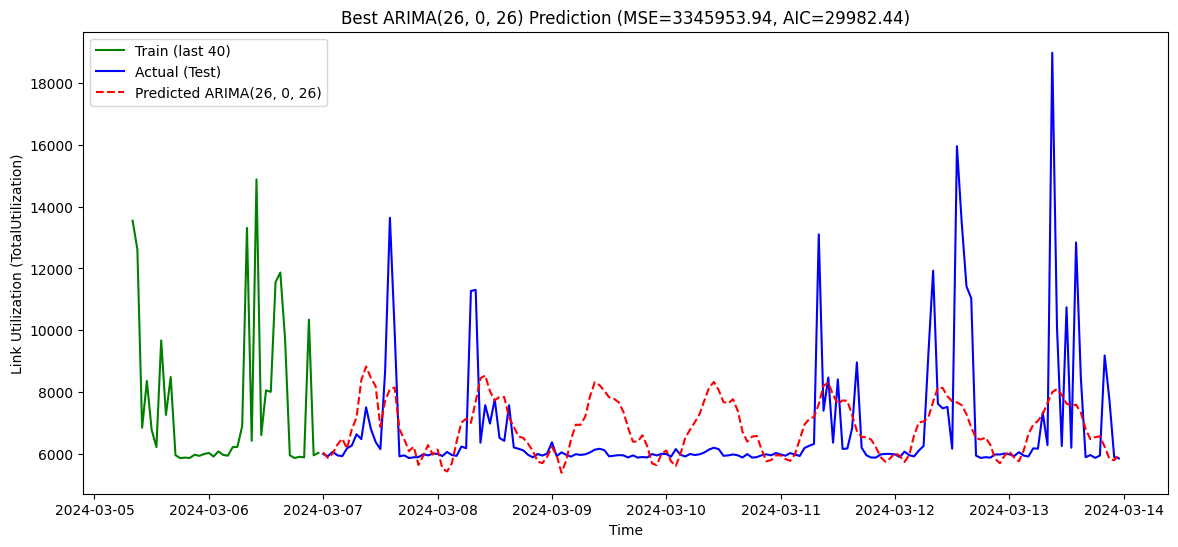

In [ ]:
# Define the train/test sets for plotting
train = series[:-168]
test = series[-168:]

# --- Plot best model ---
plt.figure(figsize=(14, 6))

# Plot the last 40 points of the training data for context
plt.plot(train.index[-40:], train[-40:],
         label="Train (last 40)", color="green")

# Plot the actual values for the test set
plt.plot(test.index, test, label="Actual (Test)", color="blue")

# Plot the ARIMA model's predictions for the test set
plt.plot(test.index, ARIMA_y_pred, label=f"Predicted ARIMA{best_order}", color="red", linestyle="--")

plt.title(f"Best ARIMA{best_order} Prediction (MSE={best_mse:.2f}, AIC={best_aic:.2f})")
plt.xlabel("Time")
plt.ylabel("Link Utilization (TotalUtilization)")
plt.legend()
plt.show()

## Task 2: ARIMA Model Performance

The second approach applied the ARIMA model, designed to capture temporal dependencies in the series.

- **R²**: 0.1470  
- **RMSE**: 1829.19  
- **MAE**: 1088.57  
- **MAPE**: 13.80%  

ARIMA underperformed compared to regression, struggling with seasonality and producing higher error variance.


### Residual of ARIMA

Re-fitting the best model: ARIMA(26, 0, 26)...
Model fitting complete.


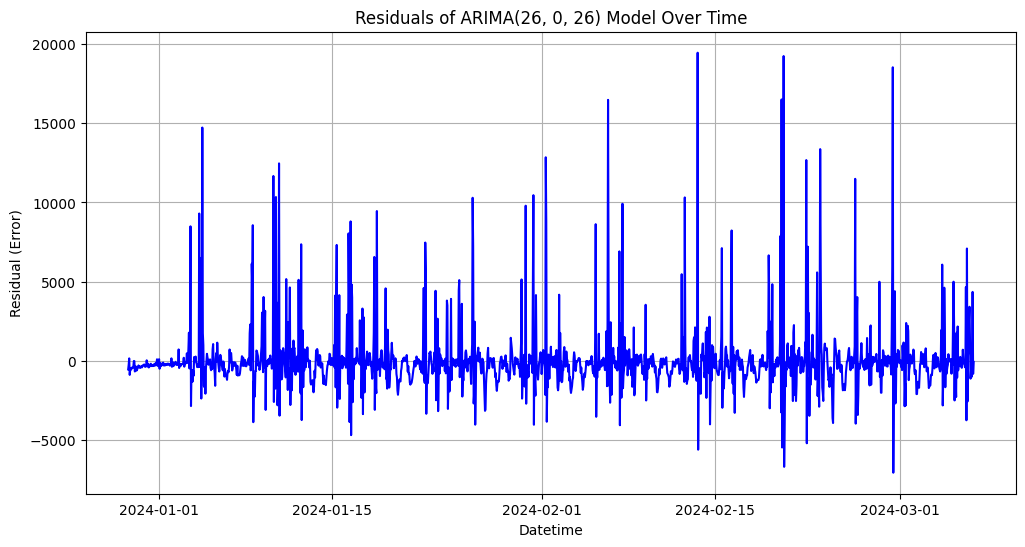

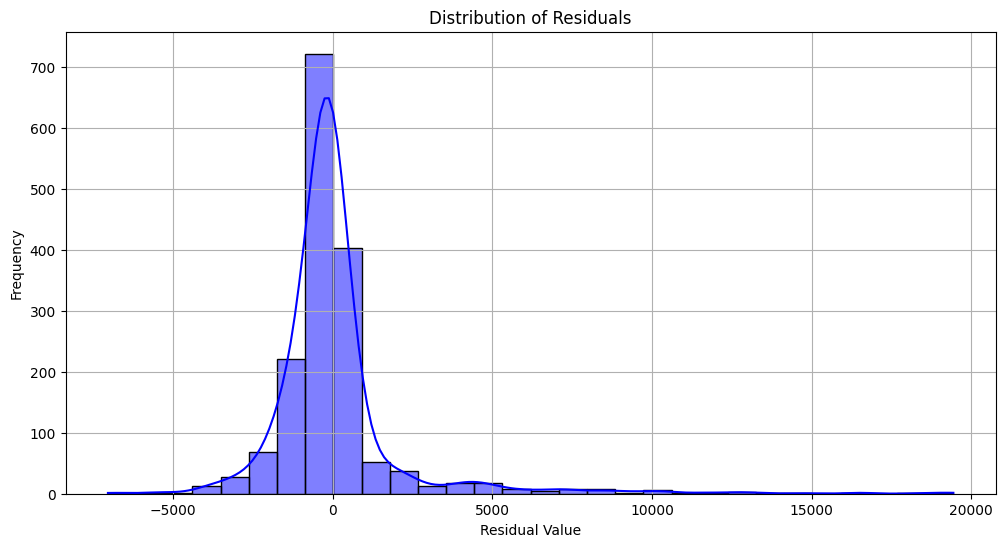


--- Residual Summary Statistics ---
count     1643.000000
mean        59.435128
std       2142.886299
min      -7042.438403
25%       -671.678876
50%       -198.316842
75%        221.006172
max      19441.925652
dtype: float64


In [ ]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --- Step 1: Re-fit the Best ARIMA Model on the Training Data ---
print(f"Re-fitting the best model: ARIMA{best_order}...")
best_model = ARIMA(train, order=best_order)
final_fit = best_model.fit()
print("Model fitting complete.")

# --- Step 2: Extract and Analyze Residuals ---
residuals = final_fit.resid

# Plot 1: Residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, color='blue')  # make line blue
plt.title(f'Residuals of ARIMA{best_order} Model Over Time')
plt.xlabel('Datetime')
plt.ylabel('Residual (Error)')
plt.grid(True)
plt.show()

# Plot 2: Distribution of residuals (Histogram and KDE)
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue', line_kws={'color': 'blue'})  # histogram + KDE in blue
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# --- Step 3: Print Summary Statistics of Residuals ---
print("\n--- Residual Summary Statistics ---")
print(residuals.describe())

## Analysis of ARIMA Model Residuals

The ARIMA model was applied to capture temporal dependencies in the time series.  
Residual analysis helps evaluate whether it successfully modeled the patterns.

---

### 1. Residuals Over Time
The ARIMA residuals remain highly variable over time, with some very large spikes.  
Although the errors fluctuate around zero, their magnitude suggests the model struggled to capture sudden changes in traffic levels.

---

### 2. Distribution of Residuals
The distribution is **right-skewed**, meaning the model often made large underestimations.  
While many errors are small, a few extremely large ones dominate, consistent with the residual spikes seen in the time-series plot.

---

### 3. Summary Statistics
Key descriptive statistics of the residuals are:  
- **mean**: 59.44 (indicating a slight upward bias in predictions)  
- **std**: 2142.89 (higher than regression, showing even larger spread)  
- **min**: -7042.44  
- **max**: 19441.93  

---

### **Conclusion**
The ARIMA model explained **14.7% of variance (R² = 0.1470)** with an **RMSE of 1829.19**.  
It performed worse than regression in terms of explained variance and showed highly dispersed residuals.  


# Task-3

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# --- Train/Test Split ---
train, test = series[:-168], series[-168:]

# --- Fit Holt-Winters Model ---
hw_model = ExponentialSmoothing(
    train,
    trend="add",
    seasonal="add",
    seasonal_periods=168   # weekly seasonality in hourly data
).fit(optimized=True)

# --- Forecast on Test Period ---
forecast_hw = hw_model.forecast(steps=len(test))

# --- Evaluation Metrics ---
mse_hw = mean_squared_error(test, forecast_hw)
rmse_hw = np.sqrt(mse_hw)
mae_hw = mean_absolute_error(test, forecast_hw)
r2_hw = r2_score(test, forecast_hw)
mape_hw = np.mean(np.abs((test - forecast_hw) / test)) * 100

print("\nHolt-Winters Model Evaluation:")
print(f"MSE   : {mse_hw:.2f}")
print(f"RMSE  : {rmse_hw:.2f}")
print(f"MAE   : {mae_hw:.2f}")
print(f"R²    : {r2_hw:.4f}")
print(f"MAPE  : {mape_hw:.2f}%")


Holt-Winters Model Evaluation:
MSE   : 3270610.35
RMSE  : 1808.48
MAE   : 992.87
R²    : 0.1662
MAPE  : 12.66%


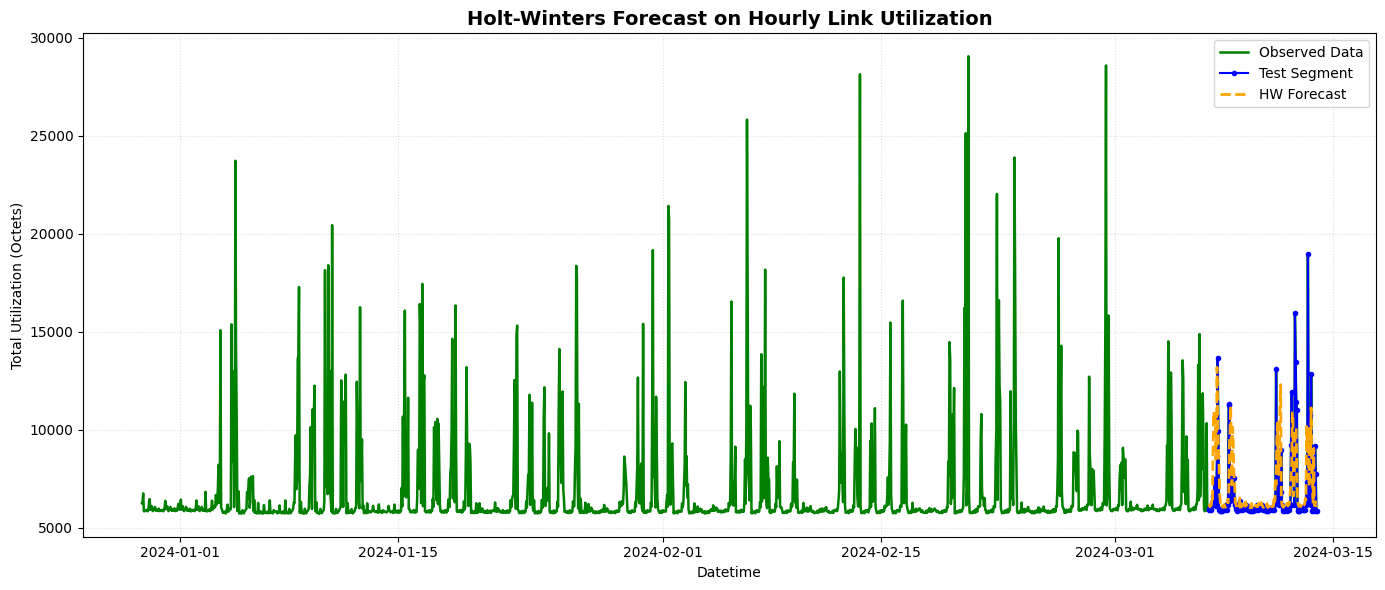

In [ ]:
# --- Plot: Entire Series vs Forecast ---
plt.figure(figsize=(14, 6))
plt.plot(series.index, series, label="Observed Data", color="green", linewidth=1.8)
plt.plot(test.index, test, label="Test Segment", color="blue", marker="o", markersize=3)
plt.plot(test.index, forecast_hw, label="HW Forecast", color="orange", linestyle="--", linewidth=2)
plt.title("Holt-Winters Forecast on Hourly Link Utilization", fontsize=14, fontweight="bold")
plt.xlabel("Datetime")
plt.ylabel("Total Utilization (Octets)")
plt.legend()
plt.grid(alpha=0.4, linestyle=":")
plt.tight_layout()
plt.show()

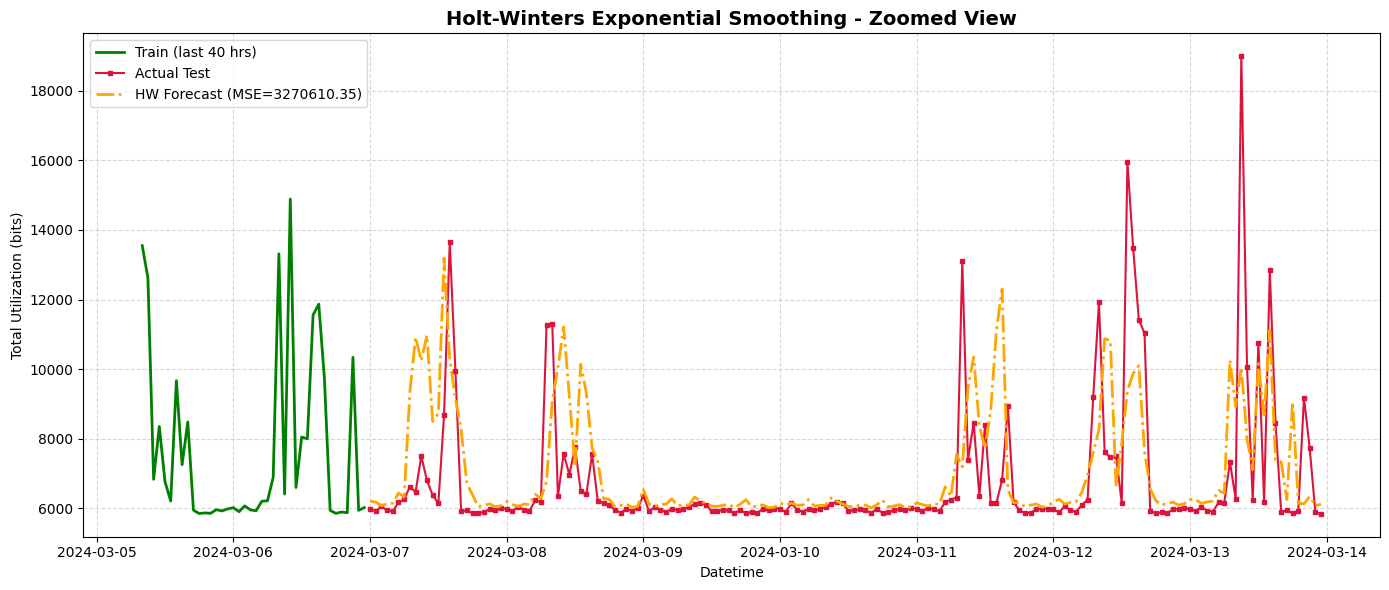

In [ ]:
# --- Plot: Focus on Last 40 Hours of Training + Test ---
plt.figure(figsize=(14, 6))
plt.plot(train.index[-40:], train.tail(40), label="Train (last 40 hrs)", color="green", linewidth=2)
plt.plot(test.index, test, label="Actual Test", color="crimson", marker="s", markersize=3)
plt.plot(test.index, forecast_hw,
         label=f"HW Forecast (MSE={mse_hw:.2f})", color="orange", linestyle="-.", linewidth=2)
plt.title("Holt-Winters Exponential Smoothing - Zoomed View", fontsize=14, fontweight="bold")
plt.xlabel("Datetime")
plt.ylabel("Total Utilization (bits)")
plt.legend(loc="upper left", fontsize=10, frameon=True)
plt.grid(alpha=0.5, linestyle="--")
plt.tight_layout()
plt.show()

## Task 3: Holt-Winters Model Performance

The third model used Holt-Winters exponential smoothing, which incorporates both trend and seasonality.

- **R²**: 0.1662  
- **RMSE**: 1808.48  
- **MAE**: 992.87  
- **MAPE**: 12.66%  

Holt-Winters performed slightly better than ARIMA, handling seasonality more effectively, but still explained limited variance.


### Residual for Holt-Winter


--- Residual Analysis for Holt-Winters Model ---


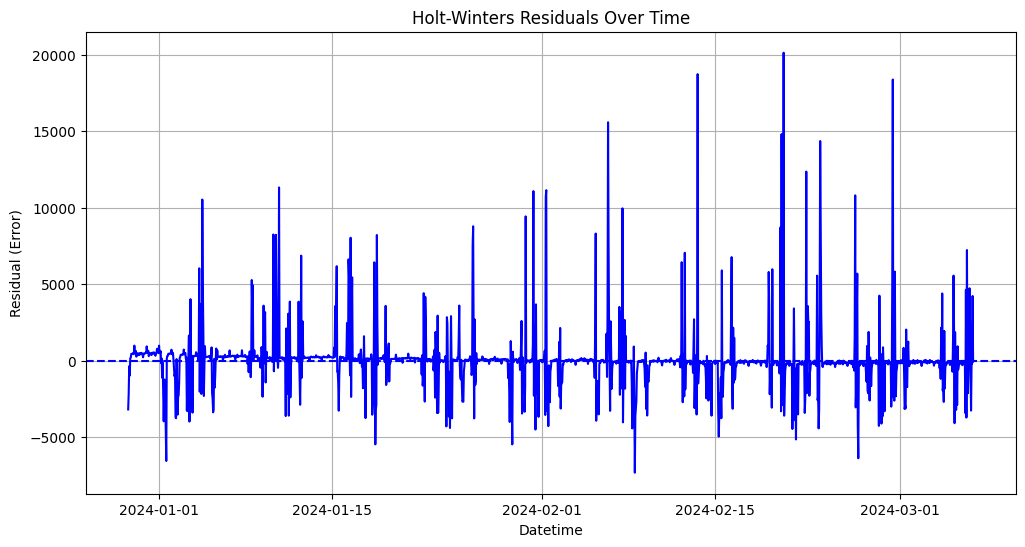

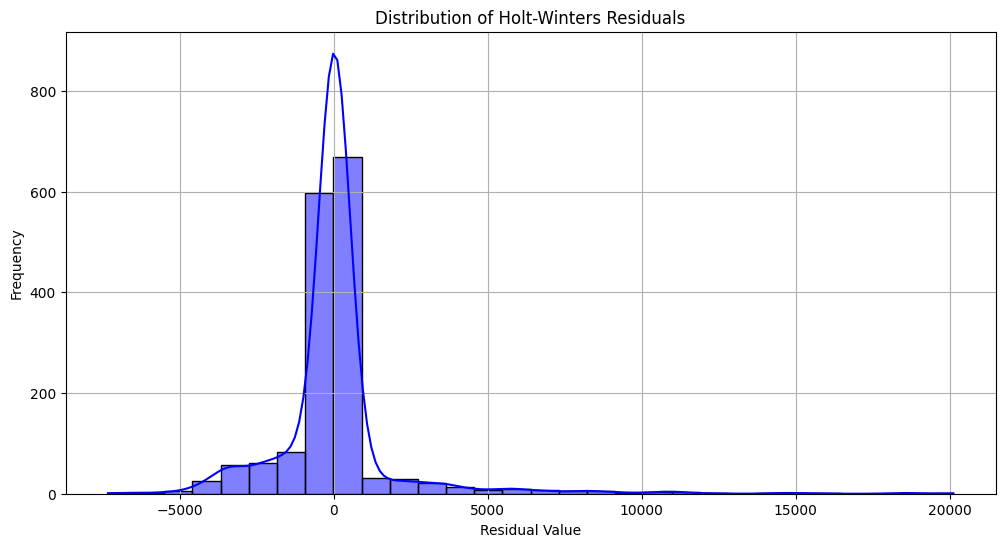


--- Residual Summary Statistics ---
count     1643.000000
mean        49.732259
std       2046.053535
min      -7327.989285
25%       -201.970758
50%        -11.510952
75%        206.190678
max      20120.457454
dtype: float64


In [ ]:
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

print("\n--- Residual Analysis for Holt-Winters Model ---")

# --- Step 1: Extract Residuals from the Training Fit ---
residuals = hw_model.resid

# --- Step 2: Create Diagnostic Plots ---

# Plot 1: Residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals.index, residuals, color='blue')  # make line blue
plt.axhline(0, color='blue', linestyle='--')        # optional: add zero line in blue
plt.title('Holt-Winters Residuals Over Time')
plt.xlabel('Datetime')
plt.ylabel('Residual (Error)')
plt.grid(True)
plt.show()

# Plot 2: Histogram + KDE
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue', line_kws={'color': 'blue'})  # blue bars + KDE
plt.title('Distribution of Holt-Winters Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# --- Step 3: Print Summary Statistics of Residuals ---
print("\n--- Residual Summary Statistics ---")
print(residuals.describe())

## Analysis of Holt-Winters Model Residuals

The Holt-Winters Exponential Smoothing model was applied to incorporate **trend and seasonality**.  
Residual analysis helps confirm whether seasonality was properly captured.

---

### 1. Residuals Over Time
Residuals are more stable compared to ARIMA, with fewer extreme deviations.  
They still show spikes during outlier traffic periods, but overall they appear more balanced around zero.

---

### 2. Distribution of Residuals
The distribution is closer to normal than ARIMA, though still not perfectly bell-shaped.  
There are occasional large positive and negative errors, but the overall spread is slightly reduced.

---

### 3. Summary Statistics
Key descriptive statistics of the residuals are:  
- **mean**: 49.73 (slight positive bias)  
- **std**: 2046.05 (smaller than ARIMA, but still high)  
- **min**: -7327.99  
- **max**: 20120.46  

---

### **Conclusion**
The Holt-Winters model achieved an **RMSE of 1808.48** and an **R² of 0.1662**.  
It performed slightly better than ARIMA, thanks to its ability to handle **seasonality**, but it still explained only ~16.6% of variance.  
Among the three models tested, Holt-Winters was the **most balanced**, though significant errors remain during unusual traffic spikes.
